In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

In [29]:
# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data Spliting

In [33]:
# Set the path to your dataset
dataset_dir = 'dangerous-insects-dataset/farm_insects'
output_dir = 'data'

# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2

# Create directories for the split datasets
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        # Get list of all images in the class folder
        images = os.listdir(class_path)
        
        # Split the images into train, validation, and test sets
        train_images, test_images = train_test_split(images, test_size=(1 - train_ratio))

        # Create class directories in the output splits
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Copy images to the respective directories
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
        
        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

print('Dataset split completed.')

Dataset split completed.


## Normalization

In [34]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print debug information
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of testing samples: {test_generator.samples}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")

Found 1579 images belonging to 15 classes.
Found 1172 images belonging to 15 classes.
Number of training samples: 1579
Number of testing samples: 1172
Number of classes: 15
Class indices: {'Africanized Honey Bees (Killer Bees)': 0, 'Aphids': 1, 'Armyworms': 2, 'Brown Marmorated Stink Bugs': 3, 'Cabbage Loopers': 4, 'Citrus Canker': 5, 'Colorado Potato Beetles': 6, 'Corn Borers': 7, 'Corn Earworms': 8, 'Fall Armyworms': 9, 'Fruit Flies': 10, 'Spider Mites': 11, 'Thrips': 12, 'Tomato Hornworms': 13, 'Western Corn Rootworms': 14}


Original Images:


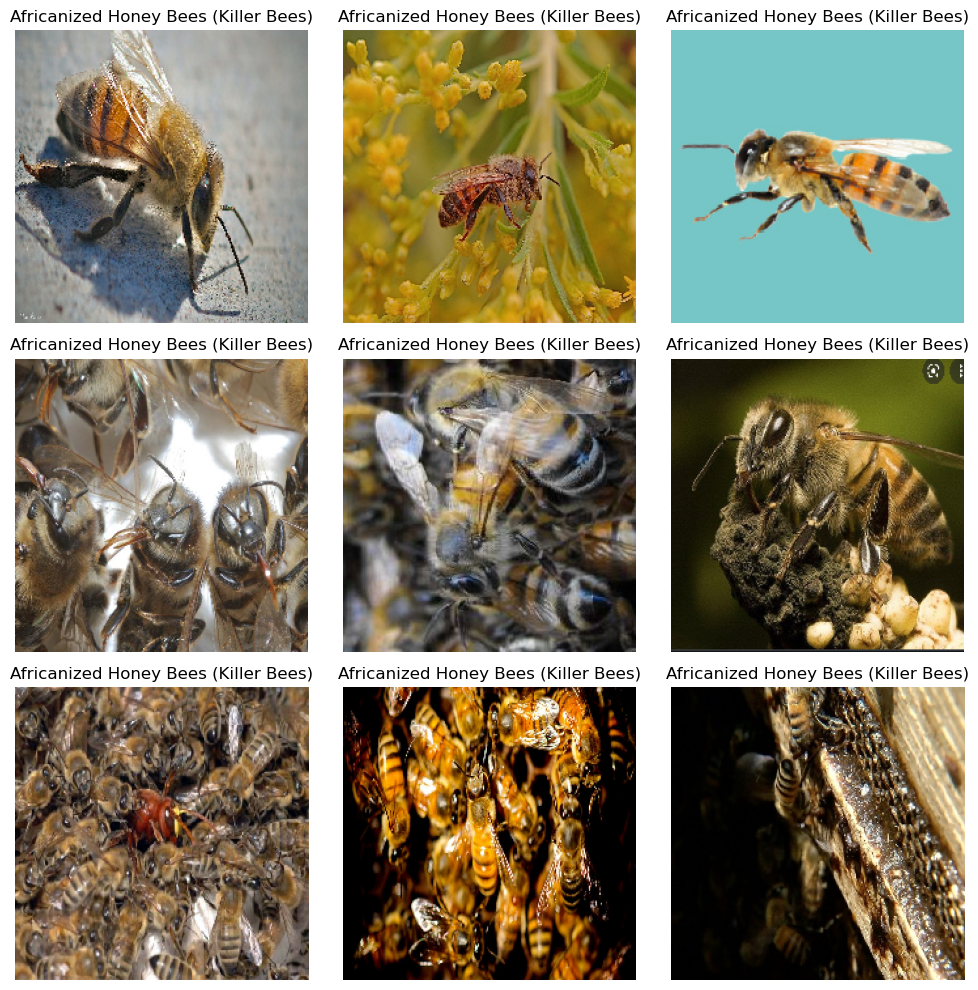

Augmented Images:


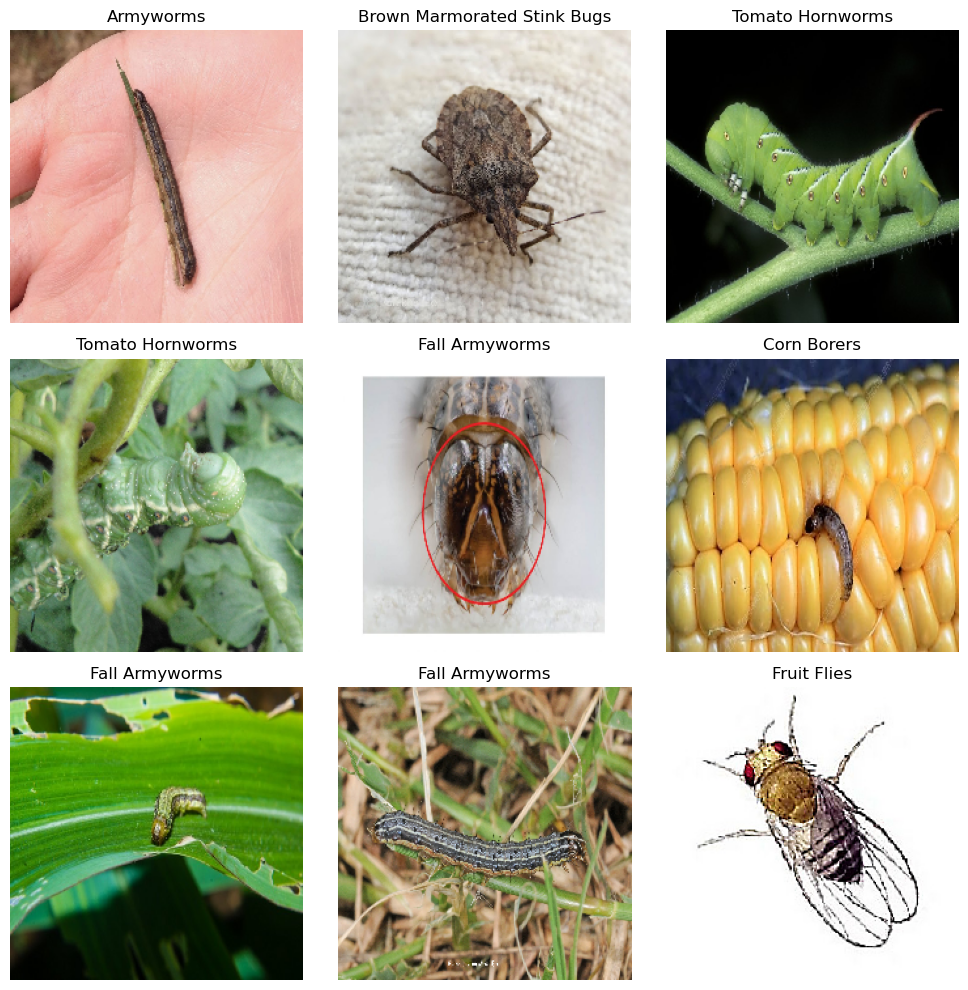

In [35]:
# Visualize some augmented images
def plot_augmented_images(generator, num_images=9):
    images, labels = next(generator)
    classes = list(generator.class_indices.keys())
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot original and augmented images
print("Original Images:")
plot_augmented_images(test_generator)

print("Augmented Images:")
plot_augmented_images(train_generator)


## Model Building

### Preparation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

### 1st Model (basic)

In [ ]:
# Define the model architecture
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Create and compile the model
num_classes = len(train_generator.class_indices)
model = create_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,826,255 (10.78 MB)

 Trainable params: 2,826,255 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 20
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = test_generator.samples // BATCH_SIZE

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=validation_steps,
        verbose=1
    )

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=validation_steps)
print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.0741 - loss: 2.7029 - val_accuracy: 0.0833 - val_loss: 2.6863
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 2.7321 - val_accuracy: 0.2000 - val_loss: 2.3031
Epoch 3/20


2024-08-12 18:17:52.981758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3018462934674661727
2024-08-12 18:17:52.981795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 798135337694839519
2024-08-12 18:17:52.981807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2161127251078669041
2024-08-12 18:17:52.981817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3570325851999499513
2024-08-12 18:17:52.981926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2117626443344433879
2024-08-12 18:17:52.981940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1638470369187721595
2024-08-12 18:17:52.981950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item

47/47 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0928 - loss: 2.7007 - val_accuracy: 0.1007 - val_loss: 2.6752
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0312 - loss: 2.6711 - val_accuracy: 0.8000 - val_loss: 1.9234
Epoch 5/20


2024-08-12 18:18:55.750884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1836475570546131124
2024-08-12 18:18:55.750929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3018462934674661727
2024-08-12 18:18:55.750942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 798135337694839519
2024-08-12 18:18:55.750952: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2161127251078669041
2024-08-12 18:18:55.750963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17482153459508266119
2024-08-12 18:18:55.750973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11700259954177099023
2024-08-12 18:18:55.750982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0907 - loss: 2.7030

### 2nd Model (ResNet50)

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [37]:
# Define the residual block
def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x

    if downsample:
        stride = 2
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

# Define the ResNet50 model
def ResNet50(input_shape=(224, 224, 3), num_classes=1000):
    inputs = Input(shape=input_shape)

    # Initial Conv layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, downsample=True)
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    # Global Average Pooling and Dense Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [38]:
# Create the model
# Create and compile the model
num_classes = len(train_generator.class_indices)
resnet_50 = ResNet50((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)
# Compile the model
resnet_50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Print the model summary
resnet_50.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_216 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_216[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_198 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 56, 56,    │          0 │ re_lu_198[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_217 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_217[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_199 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_218 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_199[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_218[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_96 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_200 (ReLU)    │ (None, 56, 56,    │          0 │ add_96[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_219 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_200[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_219[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_201 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_220 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_201[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_220[0][0]

 Total params: 21,317,903 (81.32 MB)

 Trainable params: 21,300,879 (81.26 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [39]:
# Train the model
epochs = 20
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = test_generator.samples // BATCH_SIZE

history = resnet_50.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 407s 6s/step - accuracy: 0.0972 - loss: 4.1001 - val_accuracy: 0.0703 - val_loss: 999817.4375
Epoch 2/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 4:06 5s/step - accuracy: 0.0938 - loss: 2.8430

2024-08-12 19:24:26.416094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:24:26.416902: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10018969796671341722
2024-08-12 19:24:26.417221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9423442938260649605
2024-08-12 19:24:26.417497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:24:26.417538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16291380189737386487
2024-08-12 19:24:26.417576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11165319447816734376
2024-08-12 19:24:26.417584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.0938 - loss: 2.8430 - val_accuracy: 0.0000e+00 - val_loss: 883910.8750
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.1366 - loss: 2.6641 - val_accuracy: 0.0712 - val_loss: 82.6165
Epoch 4/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - accuracy: 0.0938 - loss: 2.7688

2024-08-12 19:27:49.226723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:27:49.226783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10343432713372685258
2024-08-12 19:27:49.226807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16291380189737386487
2024-08-12 19:27:49.226822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14231983462918554079
2024-08-12 19:27:49.226840: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5523627010987197219
2024-08-12 19:27:49.226852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12695922701488063701
2024-08-12 19:27:49.226870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.0938 - loss: 2.7688 - val_accuracy: 0.0000e+00 - val_loss: 58.1570
Epoch 5/20


2024-08-12 19:27:49.831428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351
2024-08-12 19:27:49.831467: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.1732 - loss: 2.5152 - val_accuracy: 0.1068 - val_loss: 3.2975
Epoch 6/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:45 3s/step - accuracy: 0.2188 - loss: 2.3286

2024-08-12 19:30:54.980885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:30:54.980932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:30:54.981010: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10018969796671341722
2024-08-12 19:30:54.981044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13341943645855238322
2024-08-12 19:30:54.981095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11165319447816734376
2024-08-12 19:30:54.981121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9423442938260649605
2024-08-12 19:30:54.981130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2188 - loss: 2.3286 - val_accuracy: 0.0000e+00 - val_loss: 3.9168
Epoch 7/20


2024-08-12 19:30:55.578228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351


49/49 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.1813 - loss: 2.5221 - val_accuracy: 0.1120 - val_loss: 2.8351
Epoch 8/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - accuracy: 0.3750 - loss: 2.3996

2024-08-12 19:34:10.048284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:34:10.048522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:34:10.048546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10018969796671341722
2024-08-12 19:34:10.048562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16291380189737386487
2024-08-12 19:34:10.048665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11165319447816734376
2024-08-12 19:34:10.048685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13341943645855238322
2024-08-12 19:34:10.048698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous rec

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3750 - loss: 2.3996 - val_accuracy: 0.0000e+00 - val_loss: 3.1422
Epoch 9/20


2024-08-12 19:34:10.570094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351


49/49 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.1583 - loss: 2.5186 - val_accuracy: 0.1172 - val_loss: 2.7617
Epoch 10/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - accuracy: 0.3125 - loss: 2.2454

2024-08-12 19:37:22.828835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:37:22.828929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14132186579083191398
2024-08-12 19:37:22.828955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:37:22.828990: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4098358315989411340
2024-08-12 19:37:22.829003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11165319447816734376
2024-08-12 19:37:22.829074: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13341943645855238322
2024-08-12 19:37:22.829089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3125 - loss: 2.2454 - val_accuracy: 0.0000e+00 - val_loss: 3.5118
Epoch 11/20


2024-08-12 19:37:23.215839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351


49/49 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.2202 - loss: 2.4936 - val_accuracy: 0.1372 - val_loss: 2.6459
Epoch 12/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - accuracy: 0.2188 - loss: 2.3862

2024-08-12 19:40:27.876836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:40:27.876912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:40:27.876944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14746002265889875246
2024-08-12 19:40:27.876958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11165319447816734376
2024-08-12 19:40:27.876971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4098358315989411340
2024-08-12 19:40:27.876996: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13341943645855238322
2024-08-12 19:40:27.877007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2188 - loss: 2.3862 - val_accuracy: 0.0000e+00 - val_loss: 2.5800
Epoch 13/20


2024-08-12 19:40:28.658923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351


49/49 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.2099 - loss: 2.4203 - val_accuracy: 0.1068 - val_loss: 2.9394
Epoch 14/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - accuracy: 0.2188 - loss: 2.6728

2024-08-12 19:43:42.501735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:43:42.501785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:43:42.501803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10018969796671341722
2024-08-12 19:43:42.501820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11165319447816734376
2024-08-12 19:43:42.501833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13341943645855238322
2024-08-12 19:43:42.501857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9930403176874264856
2024-08-12 19:43:42.501879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2188 - loss: 2.6728 - val_accuracy: 0.0000e+00 - val_loss: 3.6737
Epoch 15/20


2024-08-12 19:43:43.086610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351


49/49 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.2110 - loss: 2.4022 - val_accuracy: 0.1276 - val_loss: 3.0913
Epoch 16/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - accuracy: 0.1875 - loss: 2.3524

2024-08-12 19:46:41.638543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:46:41.638572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:46:41.638643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10018969796671341722
2024-08-12 19:46:41.638669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11165319447816734376
2024-08-12 19:46:41.638678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16291380189737386487
2024-08-12 19:46:41.638709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13341943645855238322
2024-08-12 19:46:41.638791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous rec

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1875 - loss: 2.3524 - val_accuracy: 0.2000 - val_loss: 2.3529
Epoch 17/20


2024-08-12 19:46:42.050779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351


49/49 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.2318 - loss: 2.3680 - val_accuracy: 0.1649 - val_loss: 2.7608
Epoch 18/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/step - accuracy: 0.1562 - loss: 2.4394

2024-08-12 19:49:25.636405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:49:25.636446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16291380189737386487
2024-08-12 19:49:25.636789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:49:25.636827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10018969796671341722
2024-08-12 19:49:25.636833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14231983462918554079
2024-08-12 19:49:25.636866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13341943645855238322
2024-08-12 19:49:25.636878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous rec

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1562 - loss: 2.4394 - val_accuracy: 0.0500 - val_loss: 2.9428
Epoch 19/20


2024-08-12 19:49:25.978402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351


49/49 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.2696 - loss: 2.3180 - val_accuracy: 0.1615 - val_loss: 3.4338
Epoch 20/20
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - accuracy: 0.1875 - loss: 2.6837

2024-08-12 19:51:51.716352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8165738339645751512
2024-08-12 19:51:51.716464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10252688973352027316
2024-08-12 19:51:51.716492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10018969796671341722
2024-08-12 19:51:51.716508: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11165319447816734376
2024-08-12 19:51:51.716522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13341943645855238322
2024-08-12 19:51:51.716539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9930403176874264856
2024-08-12 19:51:51.716561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1875 - loss: 2.6837 - val_accuracy: 0.0500 - val_loss: 3.1766


2024-08-12 19:51:52.061584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17902867094018177351


: 